# Lab N
### Morphology

Skimage morphology operators' documentation:
https://scikit-image.org/docs/dev/api/skimage.morphology.html

In [1]:
from skimage.filters import sobel_h, sobel, sobel_v, roberts, prewitt
from skimage.color import rgb2gray, rgb2hsv
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
from skimage.feature import canny
from skimage.filters import median
from skimage.util import random_noise
import math
from scipy import fftpack
from scipy.signal import convolve2d
from matplotlib.pyplot import bar
from skimage.exposure import histogram
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.morphology import binary_erosion, binary_dilation, binary_closing, skeletonize, thin
from skimage.measure import find_contours
from skimage.draw import rectangle

# Show the figures / plots inside the notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Show the figures / plots inside the notebook
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 
    

def show_3d_image(img, title):
    fig = plt.figure()
    fig.set_size_inches((12,8))
    ax = fig.gca(projection='3d')

    # Make data.
    X = np.arange(0, img.shape[0], 1)
    Y = np.arange(0, img.shape[1], 1)
    X, Y = np.meshgrid(X, Y)
    Z = img[X,Y]

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(0, 8)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_title(title)
    plt.show()
    
def show_3d_image_filtering_in_freq(img, f):
    img_in_freq = fftpack.fft2(img)
    filter_in_freq = fftpack.fft2(f, img.shape)
    filtered_img_in_freq = np.multiply(img_in_freq, filter_in_freq)
    
    img_in_freq = fftpack.fftshift(np.log(np.abs(img_in_freq)+1))
    filtered_img_in_freq = fftpack.fftshift(np.log(np.abs(filtered_img_in_freq)+1))
    
    show_3d_image(img_in_freq, 'Original Image')
    show_3d_image(filtered_img_in_freq, 'Filtered Image')


def showHist(img):
    # An "interface" to matplotlib.axes.Axes.hist() method
    plt.figure()
    imgHist = histogram(img, nbins=256)
    
    bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align='center')


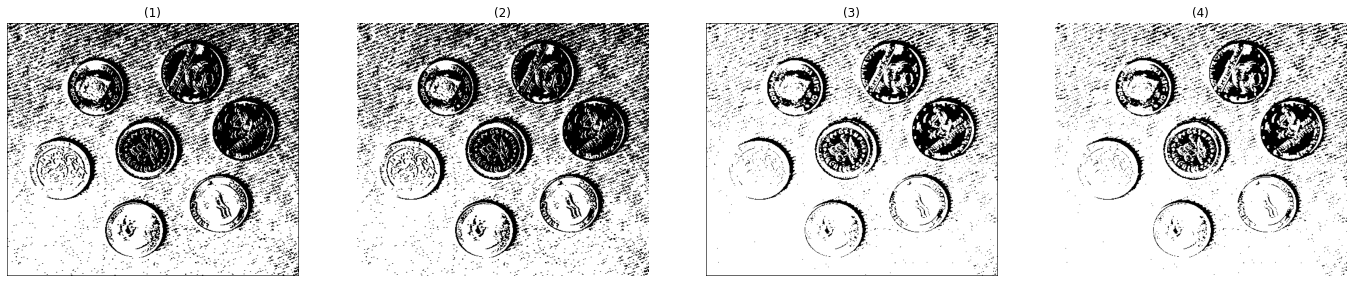

In [3]:
'''
1) Erosion / Dilation:
    - Load "coins.jpg" from the img folder
    - Convert the image to binary
    - Write 2 functions each applying 1 of the erosion/dilation algorithms (with adjustable square window size) manually to the binary image
    - Use Skimage's "binary_erosion" & "binary_dilation" & show the results
'''
coins = rgb2gray(io.imread('./imgs/coins.jpg'))
threshold = 0.5
binarized = np.where(coins > threshold, 1, 0)


def dilate(img, window):
    windowWidth = window.shape[0]
    windowHeight = window.shape[1]
    new_img = np.zeros(img.shape)
    edgeX = math.floor(windowWidth/2)
    edgeY = math.floor(windowHeight/2)
    for x in range(edgeX, img.shape[0]-edgeX):
        for y in range(edgeY, img.shape[1]-edgeY):
            hit = False
            for fx in range(windowWidth):
                for fy in range(windowHeight):
                    # (x,y) are the coordinates of the pixel we are updating in the image matrix
                    # (x-edgex,y-edgey) are the coordinates (in the image matrix) of the top left pixel of the window (filter) on placing its center on pixel (x,y)
                    # As edgex = windowWidth / 2 and edgey = windowHeight / 2
                    # (fx,fy) are just the iterators to cover the whole window (filter)
                    if window[fx][fy] != 0:
                        if window[fx][fy] == img[x+fx-edgeX][y+fy-edgeY]:
                            hit = True
            new_img[x][y] = 1 if hit == True else 0
    return new_img


def erode(img, window):
    windowWidth = window.shape[0]
    windowHeight = window.shape[1]
    new_img = np.zeros(img.shape)
    edgeX = math.floor(windowWidth/2)
    edgeY = math.floor(windowHeight/2)
    for x in range(edgeX, img.shape[0]-edgeX):
        for y in range(edgeY, img.shape[1]-edgeY):
            fit = True
            for fx in range(windowWidth):
                for fy in range(windowHeight):
                    # (x,y) are the coordinates of the pixel we are updating in the image matrix
                    # (x-edgex,y-edgey) are the coordinates (in the image matrix) of the top left pixel of the window (filter) on placing its center on pixel (x,y)
                    # As edgex = windowWidth / 2 and edgey = windowHeight / 2
                    # (fx,fy) are just the iterators to cover the whole window (filter)
                    if window[fx][fy] != 0:
                        if window[fx][fy] != img[x+fx-edgeX][y+fy-edgeY]:
                            fit = False
            new_img[x][y] = 1 if fit == True else 0
    return new_img


window = np.array([[0, 0, 0],
                   [1, 1, 0],
                   [0, 0, 0]])
show_images([erode(binarized, window), binary_erosion(binarized, window), dilate(
    binarized, window), binary_dilation(binarized, window)])


In [4]:
'''
2) Case Study: Credit Card Number Extraction
    - Load "card.jpg" from the img folder
    - Convert the image to binary by brightness thresholding maintaining the card number details for extraction
    - Use your erosion/dilation functions, or Skimage's functions only if you didn't implement them, to apply closing
        Note: The goal of this step is to join the card number into 4 sets of connected pixels
    - Use Skimage's "find_contours" to get the bounding boxes for the credit card's numbers by filtering on aspect ratio (between 2.5 & 3.5)
        Note: When using "find_contours(img, 0.8)" the o/p is a list of contours each having:
                - contour[:,0] being the Y values of the contour perimeter points
                - contour[:,1] being the X values of the contour perimeter points
'''
card = rgb2gray(io.imread('./imgs/card.jpg'))
threshold = 0.60
binarized = np.where(card > threshold, 1, 0)

window = np.ones([3, 15])
# after_closing = erode(dilate(binarized, window), window)
after_closing = binary_closing(binarized*1,selem=window)



/tmp/ipykernel_50030/3723184418.py:18: FutureWarning: `selem` is a deprecated argument name for `binary_closing`. It will be removed in version 1.0. Please use `footprint` instead.
  after_closing = binary_closing(binarized*1,selem=window)


/home/kali/miniconda3/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


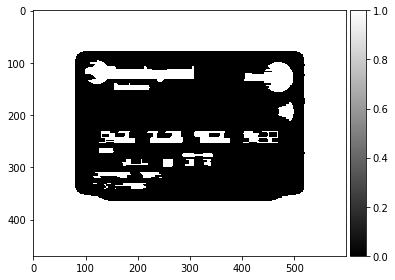

In [5]:
io.imshow(after_closing*1, cmap="gray")

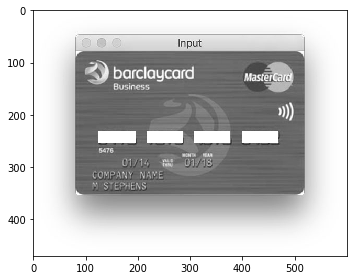

In [6]:
contours = find_contours(after_closing)

# # Display the image and plot all contours found
# fig, ax = plt.subplots()
# ax.imshow(after_closing, cmap=plt.cm.gray)
# for contour in bounding_boxes:
#     ax.plot(contour[:, 1], contour[:, 0], linewidth=2,color='red')

bounding_boxes = []
for contour in contours:
    x_coordinates = contour[:, 0]
    y_coordinates = contour[:, 1]
    x_min = x_coordinates.min()
    x_max = x_coordinates.max()
    y_min = y_coordinates.min()
    y_max = y_coordinates.max()
    aspect_ratio = (y_max - y_min)/(x_max - x_min)
    if aspect_ratio > 2.9 and aspect_ratio < 3.5:
        bounding_boxes.append([x_min, x_max, y_min, y_max])

# When provided with the correct format of the list of bounding_boxes, this section will set all pixels inside boxes in img_with_boxes
img_with_boxes = card.copy()
for box in bounding_boxes:
    [Xmin, Xmax, Ymin, Ymax] = box
    # print(Xmin,Xmax,Ymin,Ymax)
    rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=card.shape)
    # print(rr,cc)
    img_with_boxes[cc.astype('int'),rr.astype('int')] = 1 #set color white
io.imshow(img_with_boxes)


In [7]:
'''
3) Skeletonization:
    - Load "horse.jpg" from the img folder 
    - Use a binary threshold of 0.9 to remove invisible noise in the background
    - Use Skimage's "skeletonize(image)" to acquire the image's skeleton & show it
    - Use Skimage's "thin(image, max_iter)" with values of max_iter 5/10/15/20 & show it
'''


'\n3) Skeletonization:\n    - Load "horse.jpg" from the img folder \n    - Use a binary threshold of 0.9 to remove invisible noise in the background\n    - Use Skimage\'s "skeletonize(image)" to acquire the image\'s skeleton & show it\n    - Use Skimage\'s "thin(image, max_iter)" with values of max_iter 5/10/15/20 & show it\n'

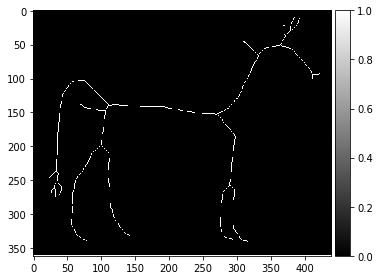

In [8]:
horse = rgb2gray(io.imread('./imgs/horse.jpg'))
threshold = 0.9
binarized = np.where(horse > threshold, 1, 0.0)
skeleton = skeletonize(binarized*1)
io.imshow(skeleton*1, cmap="gray")


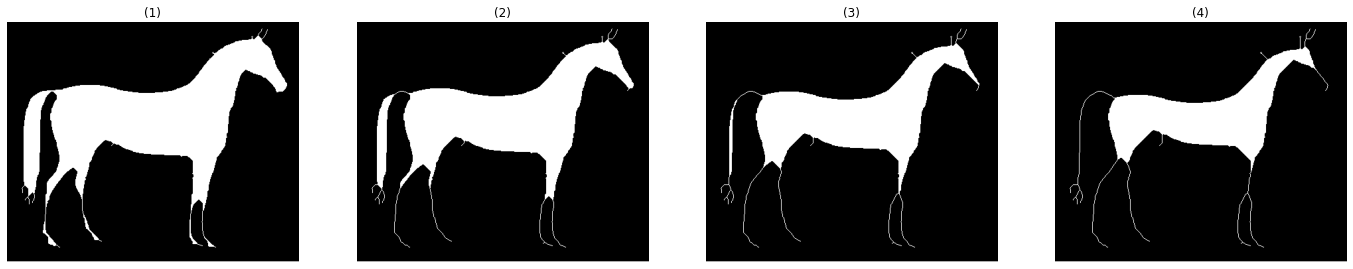

In [9]:
thinned = thin(binarized, 5)
show_images([thin(binarized, 5),thin(binarized, 10),thin(binarized, 15),thin(binarized, 20)])